<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_data_saveTheBest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import copy 

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## A brief aside on saving the highest of random numbers

In [2]:
theBest = [0, 0]

for i in range(10):

    # "train the model"
    accuracy = np.random.rand()

    # see if this is better than any previous runs
    if accuracy > theBest[0]:
        theBest = [accuracy, i]

print(f'Highest "accuracy" was {100*theBest[0]:.2f}% in run {theBest[1]+1}.')

Highest "accuracy" was 98.50% in run 5.


## Create and inspect data

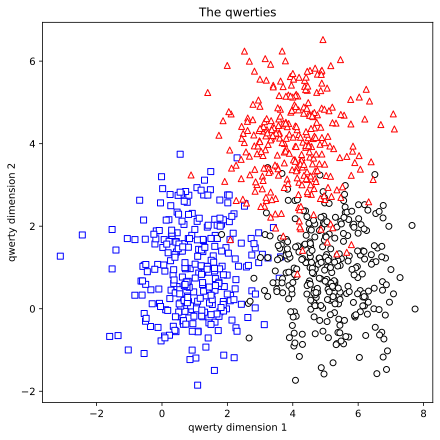

In [3]:
# create data
# create data 
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 4]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1)), np.ones((nPerClust, 1))+1))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', markerfacecolor='w')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', markerfacecolor='w')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', markerfacecolor='w')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [3*nPerClust-400, 200, 200]

# split the data
train_data, devtest_data, train_labels, devtest_labels = train_test_split(data, labels, train_size=partitions[0])

# now split the devtest data
dev_data, test_data, dev_labels, test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])

# print out the sizes
print(' Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('Devset data size: ' + str(dev_data.shape))
print('Test data size: ' + str(test_data.shape))

 Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
Devset data size: torch.Size([200, 2])
Test data size: torch.Size([200, 2])


In [5]:

# then convert into pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
dev_data = TensorDataset(dev_data, dev_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 30
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [6]:
# how many batches are there?
print(f'There are {len(train_loader)} batches, each with {batchsize} smaples.')

There are 16 batches, each with 30 smaples.


## Create and validate the model

In [7]:
# create a class for the model
def createTheQwertyNet():

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ## hidden layer
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))

            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfun, optimizer

In [8]:
# test the model with fake input

net, lossf, opt = createTheQwertyNet()
print(net)

#input is ten samples
input = torch.randn(10, 2)
net(input)

qwertyNet(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[-0.1347,  0.3616, -0.2378],
        [-0.1759,  0.2328, -0.2740],
        [-0.1499,  0.2999, -0.2670],
        [-0.1681,  0.2492, -0.2631],
        [-0.1066,  0.4984, -0.4030],
        [-0.2239,  0.2319, -0.3813],
        [-0.1286,  0.3312, -0.2268],
        [-0.1317,  0.3743, -0.2244],
        [-0.1379,  0.3290, -0.2920],
        [-0.1589,  0.2687, -0.2500]], grad_fn=<AddmmBackward0>)

# A function that trains the model

In [12]:
def function2trainTheModel():

    # New! initialize a dictionary for the best model
    theBestModel = {'Accuracy': 0, 'net': None}

    numepochs = 100

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    devAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        devAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

        # New! Store this model if it's the best so far
        if devAcc[-1] > theBestModel['Accuracy']:

            # new best accuracy
            theBestModel['Accuracy'] = devAcc[-1].item()

            # model's internal state
            theBestModel['net'] = copy.deepcopy(net.state_dict())
    # end epochs

    # function outputs
    return trainAcc, devAcc, losses, theBestModel

            


## Run the model and plot the results

In [20]:
# run the model
trainAcc, devAcc, losses, theBestModel = function2trainTheModel()

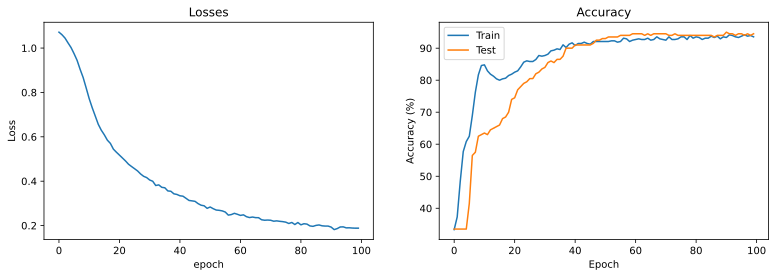

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [22]:
theBestModel

{'Accuracy': 95.0,
 'net': OrderedDict([('input.weight', tensor([[-0.5988,  0.0806],
                       [-0.1062,  0.9738],
                       [ 1.0337, -0.4229],
                       [ 0.6264,  0.6033],
                       [-0.1134, -0.4662],
                       [-0.1240, -0.6047],
                       [-0.5276,  0.7835],
                       [-0.4745,  0.3867]])),
              ('input.bias',
               tensor([-0.0613,  0.1990, -0.2665, -0.8120, -0.2998, -0.1990, -0.0339, -0.2624])),
              ('fc1.weight',
               tensor([[ 0.3357, -0.0542,  0.3823, -0.0517,  0.2703,  0.2674, -0.1236, -0.2517],
                       [ 0.2141,  0.7222, -0.1261,  0.7098,  0.2487,  0.2119, -0.1066, -0.1073],
                       [ 0.2946, -0.2153,  0.9310,  0.1459, -0.1473,  0.0644, -0.3488,  0.1761],
                       [-0.0788, -0.1911, -0.0709, -0.0024,  0.1677, -0.0406, -0.1961,  0.1969],
                       [-0.2238, -0.1105, -0.0586,  0.0737, -0.3091

In [23]:
# extract X, y from test dataloader
X, y = next(iter(test_loader))

# yHat = theBestModel['net'](X)

In [24]:
# recreate the best-performing model
bestnet = createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel['net'])

<All keys matched successfully>

In [27]:
# and run the data through TEST
X, y = next(iter(test_loader))
yHat = bestnet(X) 

bestAcc = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())
bestAcc

tensor(95.)

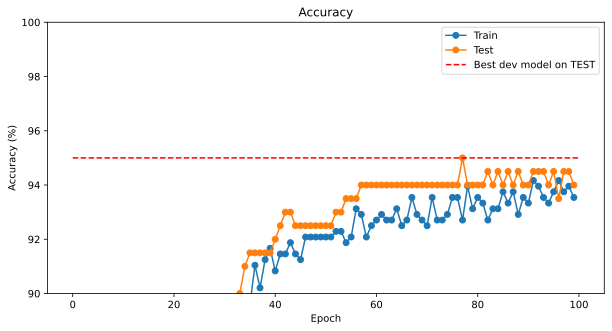

In [28]:
fig = plt.figure(figsize=(10, 5))

plt.plot(trainAcc, 'o-', label='Train')
plt.plot(devAcc, 'o-', label='Test')
plt.plot([0, len(devAcc)], [bestAcc, bestAcc], 'r--', label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy') 
plt.ylim([bestAcc-5, bestAcc+5])
plt.legend()
plt.show()
